In [2]:
from __future__ import division
import pandas as pd
import numpy as np
import datetime
import time
import matplotlib.pyplot as plt

import keras
from keras.models import Sequential
from keras.layers import Dense,Dropout,BatchNormalization,Conv1D,Flatten,MaxPooling1D,LSTM
from keras.callbacks import EarlyStopping,ModelCheckpoint,TensorBoard
from scikeras.wrappers import KerasClassifier, KerasRegressor
from keras.models import load_model
from sklearn.preprocessing import MinMaxScaler

In [3]:
# Identify stock data to grab by ticker
ticker = 'AAPL'

start_date=datetime.datetime(2016,1,6)
end_date=datetime.datetime(2021,1,5)

In [5]:
import pandas as pd 
import numpy as np
import yfinance as yf
from ta import add_all_ta_features
from sklearn.linear_model import LinearRegression

def load_and_prepare(ticker, start_date, end_date):
    # Fetch historical stock data
    df = yf.download(ticker, start=start_date , end=end_date)

    # Calculate daily returns
    df['returns'] = df['Adj Close'].pct_change()

    # Fetch market data (e.g., S&P 500)
    market_data = yf.download('^GSPC', start=df.index.min(), end=df.index.max())
    market_data['market_returns'] = market_data['Adj Close'].pct_change()

    # Combine stock and market data
    merged_data = pd.merge(df, market_data[['market_returns']], left_index=True, right_index=True, how='inner')

    # Drop rows with missing values
    merged_data.dropna(inplace=True)

    # Initialize lists to store alpha and beta values
    alpha_values = []
    beta_values = []

    # Set up X and y for linear regression
    X = merged_data['market_returns'].values.reshape(-1, 1)
    y = merged_data['returns'].values

    # Iterate through the data to calculate alpha and beta for each day
    for i in range(len(merged_data)):
        X_i = X[:i + 1]
        y_i = y[:i + 1]

        # Fit linear regression model
        model = LinearRegression()
        model.fit(X_i, y_i)

        # Extract alpha and beta for the current day
        alpha_i = model.intercept_
        beta_i = model.coef_[0]

        alpha_values.append(alpha_i)
        beta_values.append(beta_i)

    # Add alpha and beta columns to the DataFrame
    merged_data['alpha'] = alpha_values
    merged_data['beta'] = beta_values

    # Drop columns not needed for the final result
    merged_data.drop(['returns', 'market_returns'], axis=1, inplace=True)

    # Add technical analysis features
    merged_data = add_all_ta_features(merged_data, open="Open", high="High", low="Low", close="Close", volume="Volume", fillna=True)

    # Calculate target and target class
    merged_data['target'] = ((merged_data['Close'] - merged_data['Open']) / merged_data['Open']) * 100
    merged_data['target'] = merged_data['target'].shift(-1)
 
    merged_data['target_class'] = np.where(merged_data['target'] < 0, 0, 1)
    
    merged_data['target_next_close'] = merged_data['Close'].shift(-1)

    # Drop rows with missing values
    merged_data.dropna(inplace=True)

    return merged_data




In [8]:
df = load_and_prepare('AAPL', "2010-01-01" , "2024-01-01")


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


/Users/fauzanarif/Bootcamp/ds-capstone/.venv/lib/python3.11/site-packages/ta/trend.py:768: RuntimeWarning: invalid value encountered in double_scalars
  dip[i] = 100 * (self._dip[i] / self._trs[i])
/Users/fauzanarif/Bootcamp/ds-capstone/.venv/lib/python3.11/site-packages/ta/trend.py:772: RuntimeWarning: invalid value encountered in double_scalars
  din[i] = 100 * (self._din[i] / self._trs[i])


In [9]:
df

,Open,High,Low,Close,Adj Close,Volume,alpha,beta,volume_adi,volume_obv,...,momentum_roc,momentum_ppo,momentum_ppo_signal,momentum_ppo_hist,others_dr,others_dlr,others_cr,target,target_class,target_next_close
Date,,,,,,,,,,,,,,,,,,,,,
2010-01-05,7.664286,7.699643,7.616071,7.656429,6.490200,601904800,0.001729,0.000000,-2.057486e+07,601904800,...,0.000000,0.000000,0.000000,0.000000,-87.218709,0.000000,0.000000,-1.590632,0,7.534643
2010-01-06,7.656429,7.686786,7.526786,7.534643,6.386966,552160000,-0.019649,6.861476,-5.185037e+08,49744800,...,0.000000,-0.663342,-0.132668,-0.530674,-1.590632,-1.603419,-1.590632,-0.552545,0,7.520714
2010-01-07,7.562500,7.571429,7.466071,7.520714,6.375158,477131200,-0.017330,4.693584,-5.007164e+08,-427386400,...,0.000000,-2.209120,-0.547959,-1.661162,-0.184871,-0.185042,-1.772563,0.798858,1,7.570714
2010-01-08,7.510714,7.571429,7.466429,7.570714,6.417541,447610800,-0.015754,5.087207,-5.919977e+07,20224400,...,0.000000,-3.855405,-1.209448,-2.645957,0.664833,0.662633,-1.119514,-1.264089,0,7.503929
2010-01-11,7.600000,7.607143,7.444643,7.503929,6.360929,462229600,-0.016622,5.281346,-1.841516e+08,-442005200,...,0.000000,-4.942129,-1.955984,-2.986145,-0.882147,-0.886061,-1.991786,-0.702707,0,7.418571
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-20,196.899994,197.679993,194.830002,194.830002,194.830002,52242800,0.000608,1.112890,2.825088e+10,16870127800,...,2.850662,5.478232,4.664745,0.813486,-1.071393,-1.077173,2444.658960,-0.724127,0,194.679993
2023-12-21,196.100006,197.080002,193.500000,194.679993,194.679993,46482500,0.000605,1.112595,2.823504e+10,16823645300,...,0.651429,3.229345,4.377665,-1.148320,-0.076995,-0.077025,2442.699703,-0.809502,0,193.600006
2023-12-22,195.179993,195.410004,192.970001,193.600006,193.600006,37122800,0.000603,1.112573,2.821709e+10,16786522500,...,0.665557,0.040713,3.510275,-3.469562,-0.554750,-0.556294,2428.594085,-0.289240,0,193.050003


In [10]:
df.columns

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'alpha', 'beta',
       'volume_adi', 'volume_obv', 'volume_cmf', 'volume_fi', 'volume_mfi',
       'volume_em', 'volume_sma_em', 'volume_vpt', 'volume_nvi', 'volume_vwap',
       'volatility_atr', 'volatility_bbm', 'volatility_bbh', 'volatility_bbl',
       'volatility_bbw', 'volatility_bbp', 'volatility_bbhi',
       'volatility_bbli', 'volatility_kcc', 'volatility_kch', 'volatility_kcl',
       'volatility_kcw', 'volatility_kcp', 'volatility_kchi',
       'volatility_kcli', 'volatility_dcl', 'volatility_dch', 'volatility_dcm',
       'volatility_dcw', 'volatility_dcp', 'volatility_ui', 'trend_macd',
       'trend_macd_signal', 'trend_macd_diff', 'trend_sma_fast',
       'trend_sma_slow', 'trend_ema_fast', 'trend_ema_slow', 'trend_adx',
       'trend_adx_pos', 'trend_adx_neg', 'trend_vortex_ind_pos',
       'trend_vortex_ind_neg', 'trend_vortex_ind_diff', 'trend_trix',
       'trend_mass_index', 'trend_cci', 'trend_dpo', '

In [11]:
df["rapp"]=df["Close"].divide(df['Close'].shift(1)) # Should be the close of the previous close

In [12]:
df["mv_avg_short"]= df["Close"].rolling(window=5).mean()
df["mv_avg_long"]= df["Close"].rolling(window=50).mean()

In [13]:
df=df.iloc[50:,:] # WARNING: DO IT JUST ONE TIME!
print(df.index)

DatetimeIndex(['2010-03-18', '2010-03-19', '2010-03-22', '2010-03-23',
               '2010-03-24', '2010-03-25', '2010-03-26', '2010-03-29',
               '2010-03-30', '2010-03-31',
               ...
               '2023-12-13', '2023-12-14', '2023-12-15', '2023-12-18',
               '2023-12-19', '2023-12-20', '2023-12-21', '2023-12-22',
               '2023-12-26', '2023-12-27'],
              dtype='datetime64[ns]', name='Date', length=3469, freq=None)


In [14]:
len(df)

3469

In [16]:
df = df.reset_index()

In [19]:
from sklearn.model_selection import train_test_split

# Assuming 'df' is your DataFrame
train, test = train_test_split(df, test_size=600, shuffle=False)

# Display the shapes of the resulting DataFrames
print("Train shape:", train.shape)
print("Test shape:", test.shape)

Train shape: (2869, 98)
Test shape: (600, 98)


In [20]:
# This function returns the total percentage gross yield and the annual percentage gross yield

def yield_gross(df,v):
    prod=(v*df["rapp"]+1-v).prod()
    n_years=len(v)/252
    return (prod-1)*100,((prod**(1/n_years))-1)*100

In [21]:
def create_window(data, window_size = 1):    
    data_s = data.copy()
    for i in range(window_size):
        data = pd.concat([data, data_s.shift(-(i + 1))], axis = 1)
        
    data.dropna(axis=0, inplace=True)
    return(data)

Epoch 1/100
15/15 [==============================] - 17s 458ms/step - loss: 0.0035 - val_loss: 0.0087
Epoch 2/100
15/15 [==============================] - 1s 33ms/step - loss: 0.0489 - val_loss: 0.5048
Epoch 3/100
15/15 [==============================] - 0s 28ms/step - loss: 0.0089 - val_loss: 0.0490
Epoch 4/100
15/15 [==============================] - 0s 27ms/step - loss: 0.0160 - val_loss: 0.0258
Epoch 5/100
15/15 [==============================] - 0s 26ms/step - loss: 0.0145 - val_loss: 0.0160
Epoch 6/100
15/15 [==============================] - 0s 28ms/step - loss: 0.0235 - val_loss: 0.0976
Epoch 7/100
15/15 [==============================] - 0s 28ms/step - loss: 0.0400 - val_loss: 0.5988
Epoch 8/100
15/15 [==============================] - 0s 25ms/step - loss: 0.0280 - val_loss: 0.4243
Epoch 9/100
15/15 [==============================] - 0s 28ms/step - loss: 0.0128 - val_loss: 0.1060
Epoch 10/100
15/15 [==============================] - 0s 27ms/step - loss: 0.0110 - val_loss: 0.01

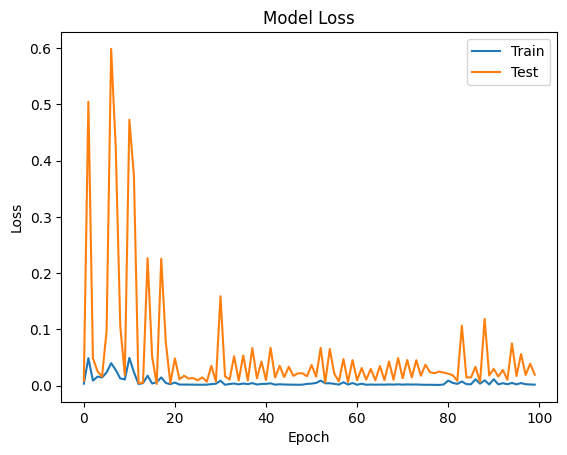

In [48]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Assuming 'df' is your DataFrame
scaler = MinMaxScaler(feature_range=(0, 1))
dg = pd.DataFrame(scaler.fit_transform(df[["High", "Low", "Open", "Close", "Volume", "mv_avg_short", "mv_avg_long"]].values))
dg0 = dg[[0, 1, 2, 3, 4, 5]]

window = 4
dfw = create_window(dg0, window)

X_dfw = np.reshape(dfw.values, (dfw.shape[0], window + 1, 6))

y_dfw = np.array(dg[6][window:])  # The Fix

# Adjust mtest based on the new shape of your data
mtest = 600

X_trainw, X_testw, y_trainw, y_testw = train_test_split(X_dfw, y_dfw, test_size=mtest, shuffle=False)

def model_lstm(window, features):
    model = Sequential()
    model.add(LSTM(300, input_shape=(window, features), return_sequences=True))
    model.add(Dropout(0.2))  # Add dropout layer with a dropout rate (fraction of input units to drop)
    model.add(LSTM(200, input_shape=(window, features), return_sequences=False))
    model.add(Dropout(0.2))  # Add dropout layer with a dropout rate
    model.add(Dense(100, kernel_initializer='uniform', activation='relu'))
    model.add(Dropout(0.2))  # Add dropout layer with a dropout rate
    model.add(Dense(1, kernel_initializer='uniform', activation='relu'))
    model.compile(loss='mse', optimizer='adam')

    return model

model = model_lstm(window + 1, 6)
history = model.fit(X_trainw, y_trainw, epochs=100, batch_size=200, validation_data=(X_testw, y_testw), \
                    verbose=1, callbacks=[], shuffle=False)  # Batch size should be no more than the square root of the # of training rows

# Plot training history
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()



In [49]:
y_pr=model.predict(X_trainw)

90/90 [==============================] - 3s 11ms/step


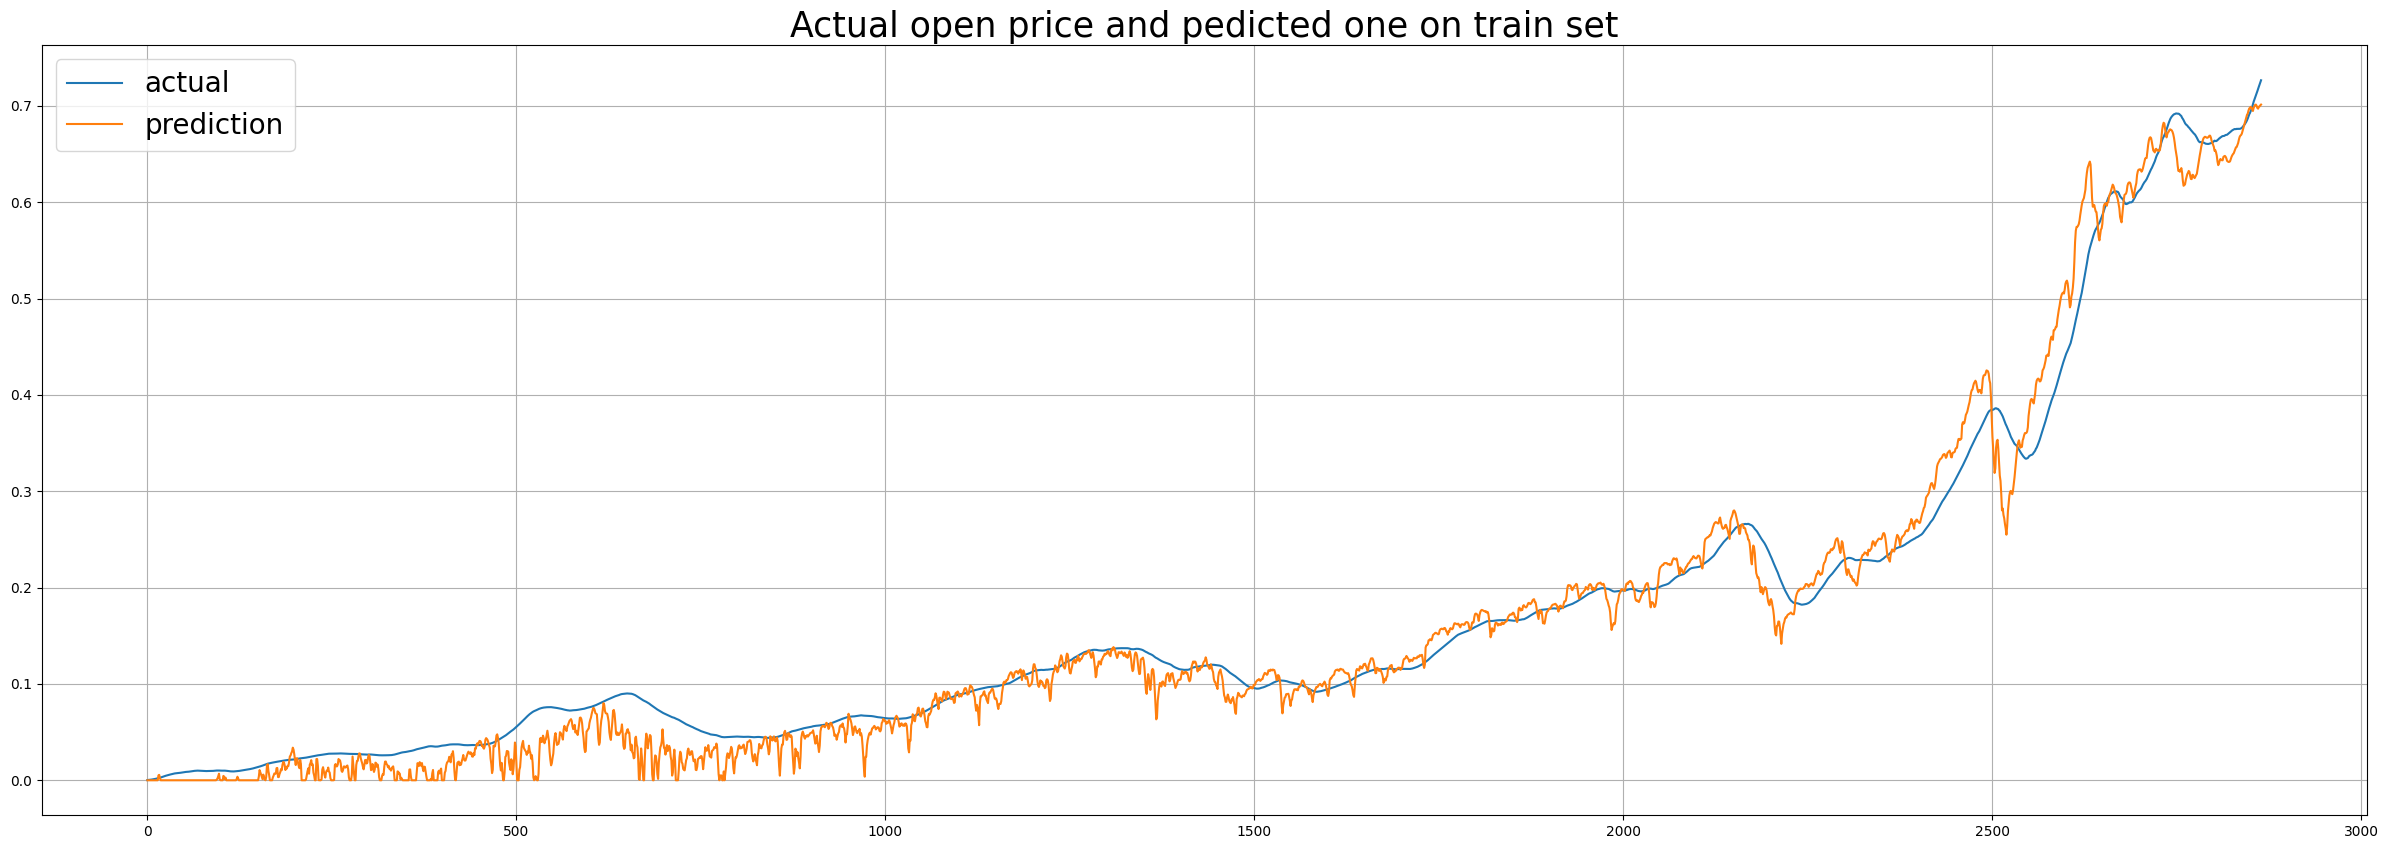

In [50]:
plt.figure(figsize=(30,10))
plt.plot(y_trainw, label="actual")
plt.plot(y_pr, label="prediction")
plt.legend(fontsize=20)
plt.grid(axis="both")
plt.title("Actual open price and pedicted one on train set",fontsize=25)
plt.show()

In [51]:
from sklearn.metrics import mean_squared_error, r2_score


# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_testw, y_pred)
print(f'Mean Squared Error (MSE): {mse}')

# Calculate other evaluation metrics as needed
# For example, you can use R-squared (R2) score
r2 = r2_score(y_testw, y_pred)
print(f'R-squared (R2) Score: {r2}')

Mean Squared Error (MSE): 0.7256603001379002
R-squared (R2) Score: -110.87232538463067


In [52]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score

# Assuming 'df' is your DataFrame
scaler = MinMaxScaler(feature_range=(0, 1))
dg = pd.DataFrame(scaler.fit_transform(df[["High", "Low", "Open", "Close", "Volume", "mv_avg_short", "mv_avg_long"]].values))
dg0 = dg[[0, 1, 2, 3, 4, 5]]

window = 4
dfw = create_window(dg0, window)

X_dfw = np.reshape(dfw.values, (dfw.shape[0], window + 1, 6))

y_dfw = np.array(dg[6][window:])  # The Fix

# Create TimeSeriesSplit object
tscv = TimeSeriesSplit(n_splits=5)  # You can adjust the number of splits as needed

mse_scores = []  # to store MSE for each fold
r2_scores = []   # to store R2 scores for each fold

# Iterate over train-test splits
for train_index, test_index in tscv.split(X_dfw):
    X_trainw, X_testw = X_dfw[train_index], X_dfw[test_index]
    y_trainw, y_testw = y_dfw[train_index], y_dfw[test_index]

    model = model_lstm(window + 1, 6)
    history = model.fit(X_trainw, y_trainw, epochs=50, batch_size=200, validation_data=(X_testw, y_testw), \
                        verbose=1, callbacks=[], shuffle=False)

    # Make predictions on the test set
    y_pred = model.predict(X_testw)

    # Evaluate the model
    mse = mean_squared_error(y_testw, y_pred)
    r2 = r2_score(y_testw, y_pred)

    mse_scores.append(mse)
    r2_scores.append(r2)

# Print average scores across folds
print(f'Average Mean Squared Error (MSE): {np.mean(mse_scores)}')
print(f'Average R-squared (R2) Score: {np.mean(r2_scores)}')


Epoch 1/50
3/3 [==============================] - 17s 3s/step - loss: 9.4184e-04 - val_loss: 0.0031
Epoch 2/50
3/3 [==============================] - 0s 80ms/step - loss: 3.9012e-04 - val_loss: 0.0017
Epoch 3/50
3/3 [==============================] - 0s 77ms/step - loss: 3.4331e-04 - val_loss: 0.0010
Epoch 4/50
3/3 [==============================] - 0s 62ms/step - loss: 5.1369e-04 - val_loss: 0.0011
Epoch 5/50
3/3 [==============================] - 0s 72ms/step - loss: 4.9545e-04 - val_loss: 0.0014
Epoch 6/50
3/3 [==============================] - 0s 66ms/step - loss: 4.3252e-04 - val_loss: 0.0016
Epoch 7/50
3/3 [==============================] - 0s 56ms/step - loss: 3.9987e-04 - val_loss: 0.0017
Epoch 8/50
3/3 [==============================] - 0s 54ms/step - loss: 3.7625e-04 - val_loss: 0.0017
Epoch 9/50
3/3 [==============================] - 0s 56ms/step - loss: 3.4908e-04 - val_loss: 0.0015
Epoch 10/50
3/3 [==============================] - 0s 55ms/step - loss: 3.2487e-04 - val_los

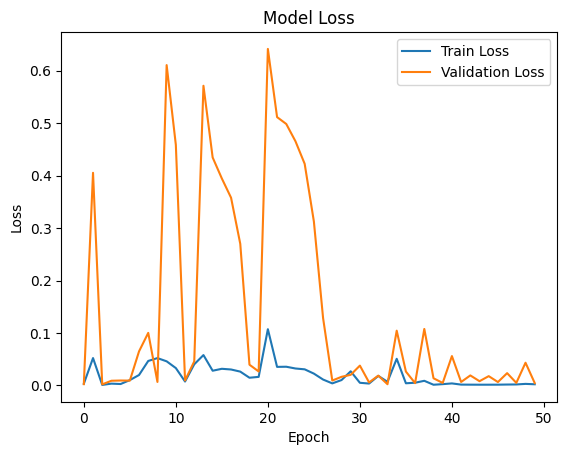

In [53]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


19/19 [==============================] - 0s 8ms/step


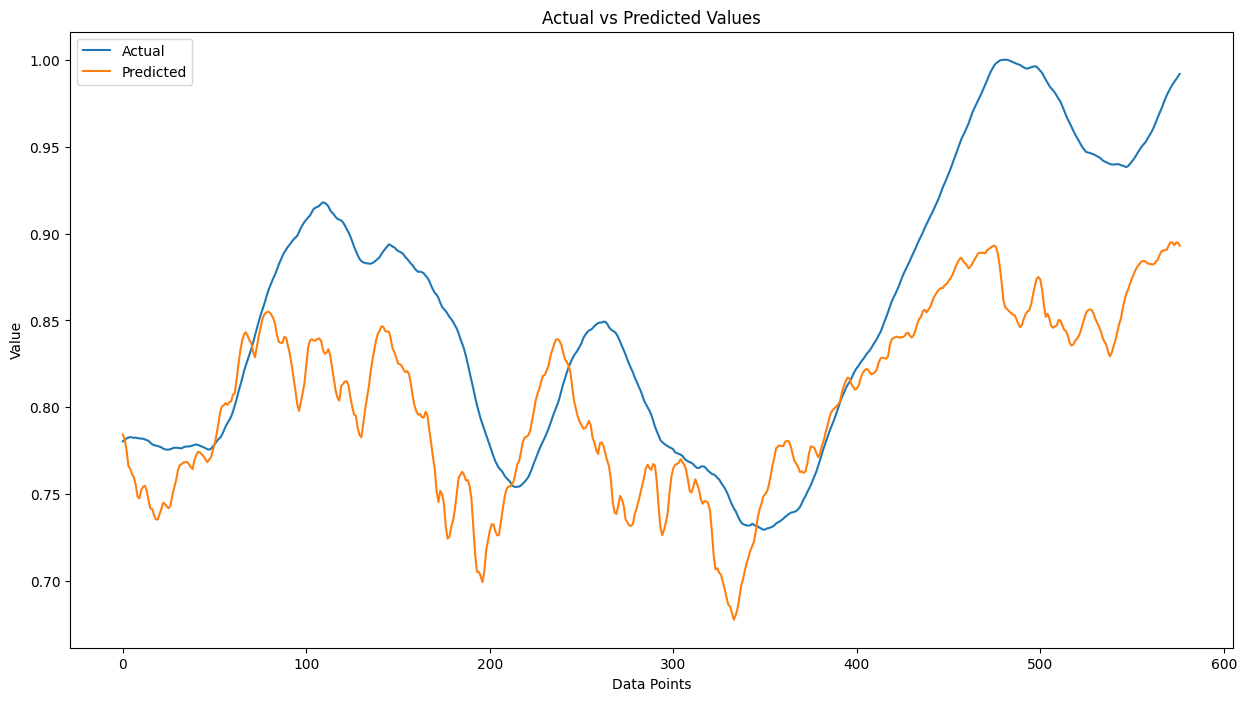

In [54]:
y_pred = model.predict(X_testw)

plt.figure(figsize=(15, 8))
plt.plot(y_testw, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.title('Actual vs Predicted Values')
plt.xlabel('Data Points')
plt.ylabel('Value')
plt.legend()
plt.show()


In [55]:
from sklearn.metrics import mean_squared_error, r2_score

mse = mean_squared_error(y_testw, y_pred)
r2 = r2_score(y_testw, y_pred)

print(f'Mean Squared Error (MSE): {mse}')
print(f'R-squared (R2) Score: {r2}')


Mean Squared Error (MSE): 0.004609471014310427
R-squared (R2) Score: 0.27735936981391685


In [57]:
# Evaluate the model on the test set
loss = model.evaluate(X_testw, y_testw)
print(f'Test Loss (MSE): {loss}')


19/19 [==============================] - 0s 9ms/step - loss: 0.0046
Test Loss (MSE): 0.004609471652656794


In [60]:
from sklearn.metrics import mean_squared_error

# Assuming 'model' is your trained model
y_pred = model.predict(X_testw)

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_testw, y_pred)
print(f'Mean Squared Error (MSE): {mse}')


19/19 [==============================] - 0s 8ms/step
Mean Squared Error (MSE): 0.004609471014310427


In [61]:
# Use the last window days of data to predict the next day's price
last_window_data = X_dfw[-1:]
predicted_price = model.predict(last_window_data)

1/1 [==============================] - 0s 60ms/step


In [62]:
predicted_price

array([[0.8930703]], dtype=float32)

19/19 [==============================] - 0s 7ms/step


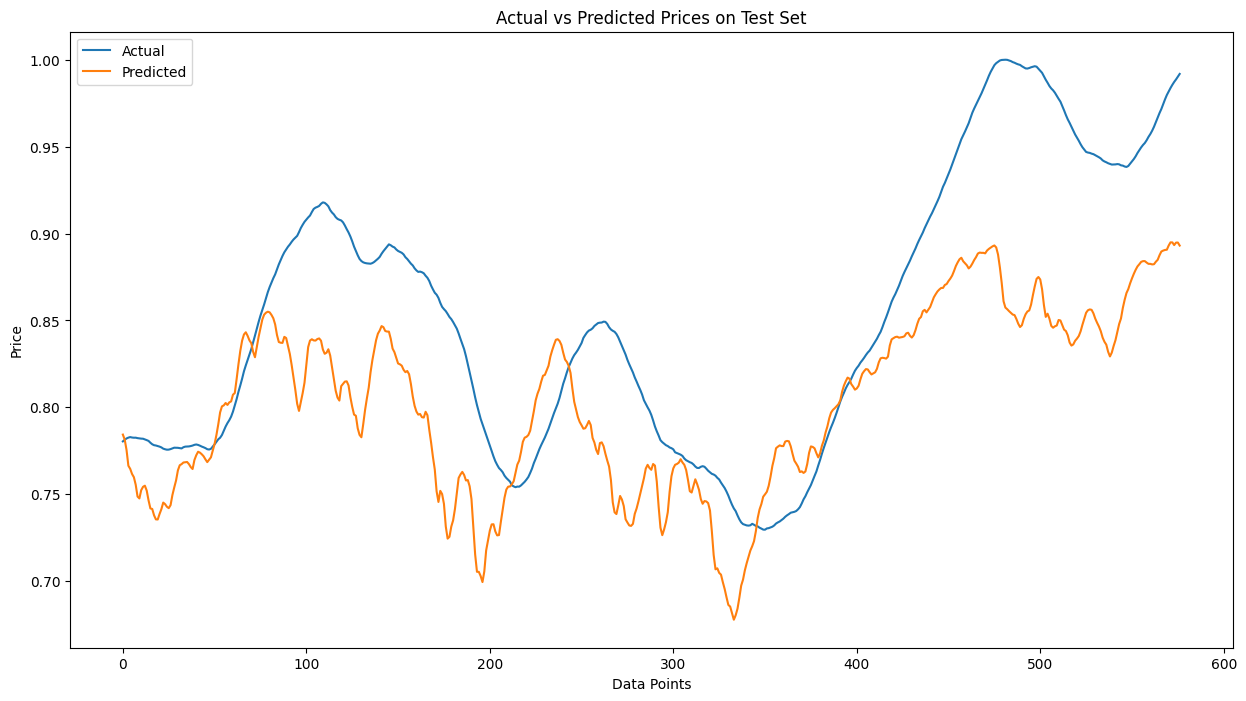

In [63]:
y_pred = model.predict(X_testw)

plt.figure(figsize=(15, 8))
plt.plot(y_testw, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.title('Actual vs Predicted Prices on Test Set')
plt.xlabel('Data Points')
plt.ylabel('Price')
plt.legend()
plt.show()


In [67]:
X_testw


array([[[0.77889626, 0.77559975, 0.7735951 , 0.78219775, 0.03135788,
         0.77021527],
        [0.77774794, 0.77344052, 0.78416589, 0.7738895 , 0.02712615,
         0.77368069],
        [0.77289371, 0.77328253, 0.77632986, 0.76842081, 0.01790969,
         0.77532889],
        [0.76960532, 0.74563407, 0.77375287, 0.74160302, 0.06292303,
         0.77038433],
        [0.74841361, 0.7458974 , 0.75077056, 0.74465289, 0.04219608,
         0.76536582]],

       [[0.77774794, 0.77344052, 0.78416589, 0.7738895 , 0.02712615,
         0.77368069],
        [0.77289371, 0.77328253, 0.77632986, 0.76842081, 0.01790969,
         0.77532889],
        [0.76960532, 0.74563407, 0.77375287, 0.74160302, 0.06292303,
         0.77038433],
        [0.74841361, 0.7458974 , 0.75077056, 0.74465289, 0.04219608,
         0.76536582],
        [0.74658679, 0.73620729, 0.74929802, 0.73713336, 0.04590754,
         0.75631135]],

       [[0.77289371, 0.77328253, 0.77632986, 0.76842081, 0.01790969,
         0.775328